Model Development:

Benchmarking KNN/Logistic Regression, Random Forest, and XGBoost to find the optimal balance of precision and recall.

Baseline: KNN and Logistic Regression
Ensemble: Random Forest
Gradient Boosting: XGBoost (Optimized via RandomizedSearchCV)

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Load the  data we processed earlier
X_train_imbalanced= pd.read_csv('../data/processed/X_train_imbalanced.csv')
y_train_imbalanced= pd.read_csv('../data/processed/y_train_imbalanced.csv')
X_train_balanced= pd.read_csv('../data/processed/X_train_balanced.csv')
y_train_balanced= pd.read_csv('../data/processed/y_train_balanced.csv')
X_test_final= pd.read_csv('../data/processed/X_test_final.csv')
y_test_final= pd.read_csv('../data/processed/y_test_final.csv')

We will focus on:

Recall: Of all people who actually wanted to subscribe, how many did we find?

F1-Score: The balance between finding everyone and not annoying too many uninterested people.

For a bank, the Cost of a False Negative (missing a customer who would have said "yes") is much higher than a False Positive (calling someone who says "no"). SMOTE helps the model learn the "fine details" of the minority class (the "yes" group) so it doesn't just treat them as noise.

### KNN and Logistic Regression

build a Baseline on the imbalanced data first to see how bad the "lazy model" problem is. Then they apply SMOTE to see if performance (specifically Recall and F1-Score) improves.

**The Baseline (Logistic Regression & KNN)**

Let's start with original X_train_final and y_train_numeric. We will evaluate them using a Classification Report because Accuracy will lie to us here.

1.1 Logistic Regression
Good for understanding feature importance (coefficients).

In [5]:
# 1.1 Logistic Regression
# Good for understanding feature importance (coefficients).

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_imbalanced, y_train_imbalanced)

# Predict and Evaluate
y_pred_log = log_reg.predict(X_test_final)

print("--- Logistic Regression Baseline ---")
print(classification_report(y_test_final, y_pred_log))

--- Logistic Regression Baseline ---
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7985
           1       0.62      0.37      0.46      1058

    accuracy                           0.90      9043
   macro avg       0.77      0.67      0.70      9043
weighted avg       0.88      0.90      0.89      9043



C:\Users\jalpa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [6]:
# 1.2 K-Nearest Neighbors (KNN)
# Good for seeing if "similar customers" behave the same way.

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_imbalanced, y_train_imbalanced)

y_pred_knn = knn.predict(X_test_final)

print("--- KNN Baseline ---")
print(classification_report(y_test_final, y_pred_knn))

C:\Users\jalpa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neighbors\_classification.py:243: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


--- KNN Baseline ---
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      7985
           1       0.51      0.37      0.42      1058

    accuracy                           0.88      9043
   macro avg       0.71      0.66      0.68      9043
weighted avg       0.87      0.88      0.88      9043



Look at the Recall for Class 1 (the "yes" group).

If the Recall is very low (e.g., 0.20), the model is missing 80% of your potential customers.

If that happens, that is our cue to stop and apply SMOTE before moving to the Ensemble models.

Since the baseline models on imbalanced data usually struggle to identify the "yes" customers (low recall), we apply SMOTE to the training data. This forces the model to treat the subscription class as equally important as the rejection class.

Industrial Context: In banking, we usually prefer the SMOTE version. Even if we call a few people who aren't interested (lower precision), the cost of a phone call is cheap compared to the profit of finding a customer who actually wants a long-term deposit (higher recall).

In [7]:
# SMOTE Implementation & Re-Training Baselines
# We will use imblearn to balance the training set and then re-run your requested Logistic Regression and KNN.

#from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Apply SMOTE only to the TRAINING data
#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train_final, y_train_numeric)

#print(f"Post-SMOTE Class Distribution: {Counter(y_train_resampled)}")

# --- 2. SMOTE Logistic Regression ---
log_reg_smote = LogisticRegression(max_iter=1000)
log_reg_smote.fit(X_train_balanced, y_train_balanced)

y_pred_log = log_reg_smote.predict(X_test_final)

print("\n--- Logistic Regression (With SMOTE) ---")
print(classification_report(y_test_final, y_pred_log))

# --- 3. SMOTE KNN ---
knn_smote = KNeighborsClassifier(n_neighbors=5)
knn_smote.fit(X_train_balanced, y_train_balanced)

y_pred_knn = knn_smote.predict(X_test_final)

print("\n--- KNN (With SMOTE) ---")
print(classification_report(y_test_final, y_pred_knn))

C:\Users\jalpa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



--- Logistic Regression (With SMOTE) ---
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      7985
           1       0.36      0.84      0.50      1058

    accuracy                           0.81      9043
   macro avg       0.67      0.82      0.69      9043
weighted avg       0.90      0.81      0.84      9043



C:\Users\jalpa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neighbors\_classification.py:243: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)



--- KNN (With SMOTE) ---
              precision    recall  f1-score   support

           0       0.96      0.79      0.87      7985
           1       0.32      0.76      0.45      1058

    accuracy                           0.79      9043
   macro avg       0.64      0.78      0.66      9043
weighted avg       0.89      0.79      0.82      9043



### Phase 2: Ensemble Learning (Random Forest)

Now that we have established how SMOTE helps our baselines, we move to Random Forest. Random Forests are excellent for banking data because they handle non-linear relationships and the high-dimensionality from your One-Hot Encoding very well.

We will use the Balanced (SMOTE) data. Random Forests are great because they provide Feature Importance, telling us which of your engineered features actually drove the predictions.

**Why Random Forest?**

Handles Complexity: It can find non-linear patterns (e.g., "Duration matters, but only for people with high balances").

Stability: By averaging 100 different trees, it reduces the risk of overfitting to the synthetic SMOTE noise.

In [8]:
# Random Forest without hyperparameter tunning

from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Fit on Balanced Data
rf_model.fit(X_train_balanced, y_train_balanced)

# Predict on the ORIGINAL Test Data (The real-world check)
y_pred_rf = rf_model.predict(X_test_final)

print("--- Random Forest (SMOTE Balanced) ---")
print(classification_report(y_test_final, y_pred_rf))

C:\Users\jalpa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


--- Random Forest (SMOTE Balanced) ---
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      7985
           1       0.47      0.62      0.53      1058

    accuracy                           0.87      9043
   macro avg       0.71      0.76      0.73      9043
weighted avg       0.89      0.87      0.88      9043



### what is hyperparameter tuning and when it comes?

Think of a Machine Learning model like a high-end espresso machine.

Parameters: These are the internal settings the machine learns itself (how much pressure to apply, how hot the water gets based on the beans). The model "learns" these during training.

Hyperparameters: These are the knobs and dials on the outside that you must set before the machine even starts (the grind size, the water-to-coffee ratio). If you set these wrong, even the best beans will produce terrible coffee.

**What is Hyperparameter Tuning?**

Hyperparameter tuning is the process of finding the "Sweet Spot" for these external settings to get the best performance out of your model.

For example, in your upcoming XGBoost model, hyperparameters include:

n_estimators: How many trees should we build? (Too many = slow/overfit; too few = underfit).

max_depth: How deep can each tree go? (Deeper trees capture more detail but can become "obsessed" with noise).

learning_rate: How much should each new tree "correct" the errors of the previous one?

**When does it come?**

In the Data Science Lifecycle, tuning happens in the Model Optimization phase, which is exactly where you are right now.

Data Cleaning/EDA (Done ✅)

Feature Engineering (Done ✅)

Preprocessing & Scaling (Done ✅)

Baseline Modeling (we just did this with Logistic Reg/KNN/RF ✅)

Hyperparameter Tuning (THIS STEP ⬅️)

Final Evaluation & Deployment

How do we do it?
We don't just guess. We use strategies like:

Grid Search: Testing every possible combination (very slow, but thorough).

Randomized Search: Picking random combinations from a grid (much faster and usually just as good).

### On what models we can do hyperparmeter tunning?

You can perform hyperparameter tuning on virtually any machine learning model that has "external" settings (knobs) that aren't learned automatically from the data.

However, the "dials" you turn are different for every model. Here is a breakdown of the most common models and the specific hyperparameters we usually tune:

1. Linear & Baseline Models
These are simple, but tuning their "Regularization" (which prevents them from overreacting to noise) is critical.

Logistic Regression:

C: Inverse of regularization strength (smaller values = stronger regularization).

penalty: Type of regularization (l1 or l2).

K-Nearest Neighbors (KNN):

n_neighbors: Number of neighbors to look at (usually 3, 5, or 11).

weights: Whether closer neighbors should have more influence (uniform vs. distance).

2. Tree-Based Models (The "Knob" Heavyweights)
These models have the most hyperparameters because trees are very prone to overfitting if not "pruned" correctly.

Decision Trees / Random Forest:

n_estimators: Number of trees in the forest.

max_depth: How deep the trees grow.

min_samples_split: Minimum data points required to split a node.

max_features: The number of features to consider when looking for the best split.

3. Gradient Boosting (XGBoost, LightGBM, CatBoost)
These are the most sensitive to tuning. A well-tuned XGBoost can often outperform a "stock" version by 5-10%.

XGBoost Specifics:

learning_rate (eta): How much we shrink the weights of new trees.

gamma: Minimum loss reduction required to make a further partition.

subsample: The fraction of observations to be randomly samples for each tree.

4. Support Vector Machines (SVM)
Kernel: The mathematical function used to transform data (linear, poly, rbf).

Gamma: Defines how far the influence of a single training example reaches.


Model Complexity,Tuning Effort,Payoff
Logistic Regression,Low,Moderate
KNN,Low,Low
Random Forest,Moderate,High
XGBoost / LightGBM,High,Very High
Deep Learning,Extreme,Massive


Since we’ve already built the Baseline Logistic Regression and KNN, don't spend too much time tuning them. Their "ceiling" is usually lower.

Our biggest ROI (Return on Investment) will come from tuning Random Forest and XGBoost. These models are complex enough that finding the right settings can significantly boost Recall for the "Yes" customers.

How do we do Hyperparameter tunning?

We don't just guess. We use strategies like:

- Grid Search: Testing every possible combination (very slow, but thorough).

- Randomized Search: Picking random combinations from a grid (much faster and usually just as good).

### let's use a Grid Search(Hyperparameter tunning) for Random Forest.

The difference is that GridSearchCV is exhaustive—it will try every single combination of the settings you provide. This is perfect for Random Forest because it is more stable and less sensitive than XGBoost, so a tighter search usually yields the best "Final Model."

**Hyperparameter Tuning: Random Forest (Grid Search)**

We will focus on max_depth and min_samples_split to control overfitting, and n_estimators to ensure the forest is dense enough to capture the "Yes" signals from SMOTE data.

In [9]:
# Hyperparameter Tuning: Random Forest (Grid Search)
# We will focus on max_depth and min_samples_split to control overfitting, 
# and n_estimators to ensure the forest is dense enough to capture the "Yes" signals from SMOTE data.


from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1. Define the Parameter Grid
# We focus on the knobs that prevent the trees from memorizing noise
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# 2. Initialize the Grid Search
# cv=5 means 5-fold cross-validation (very robust)
grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    scoring='f1', # We optimize for F1 to balance Precision and Recall
    n_jobs=-1,
    verbose=1
)

# 3. Fit on the Balanced Data
grid_rf.fit(X_train_balanced, y_train_balanced)

# 4. Best parameters found
print(f"Best RF Parameters: {grid_rf.best_params_}")

# 5. Final Evaluation on the REAL (Imbalanced) Test Data
best_rf = grid_rf.best_estimator_
y_pred_grid_rf = best_rf.predict(X_test_final)

print("\n--- Tuned Random Forest Classification Report ---")
print(classification_report(y_test_final, y_pred_grid_rf))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\jalpa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\jalpa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best RF Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 200}

--- Tuned Random Forest Classification Report ---
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      7985
           1       0.48      0.60      0.53      1058

    accuracy                           0.88      9043
   macro avg       0.71      0.76      0.73      9043
weighted avg       0.89      0.88      0.88      9043



How to Read the Output

Cross-Validation (CV): By using cv=5, the model was trained and tested 5 different times on different "slices" of data. This ensures the hyperparameters work for the whole dataset, not just one lucky split.

The F1 Score: Because used SMOTE, you will likely see that the F1 score for the "Yes" group is higher than it was in our baseline models. This means we are finding customers without calling every single person in the database.

### Phase 3 : Implementation: Optimized XGBoost

let's use RandomizedSearchCV to find the best knobs for our XGBoost model. This will automatically try different settings and tell us which one handles our bank data best.

In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# 1. Initialize the model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# 2. Define the "Search Grid" (The knobs we want to turn)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# 3. Setup the Search (cv=3 means it will cross-validate 3 times for each combo)
xgb_search = RandomizedSearchCV(
    estimator=xgb, 
    param_distributions=param_grid, 
    n_iter=10, 
    scoring='f1', 
    cv=3, 
    verbose=1, 
    random_state=42, 
    n_jobs=-1
)

# 4. Fit on the Balanced Data
xgb_search.fit(X_train_balanced, y_train_balanced)

# 5. Best settings found
print(f"Best Parameters: {xgb_search.best_params_}")

# 6. Final Evaluation
y_pred_xgb = xgb_search.predict(X_test_final)
print("\n--- Optimized XGBoost Classification Report ---")
print(classification_report(y_test_final, y_pred_xgb))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\jalpa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:199: UserWarning: [00:07:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

--- Optimized XGBoost Classification Report ---
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      7985
           1       0.46      0.69      0.56      1058

    accuracy                           0.87      9043
   macro avg       0.71      0.79      0.74      9043
weighted avg       0.90      0.87      0.88      9043



To crown a "Best Model,"

we need to compare all 4 of them side-by-side using the same metrics. In banking, we look at the F1-Score and Recall, because missing a customer (False Negative) is usually more expensive than a short unsuccessful phone call (False Positive).

In [11]:
# Best Model: comparing result
# This script collects the results from your four models and presents them in a single table for decision-making.

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# List of models and their predictions
models = {
    "Logistic Regression": y_pred_log,
    "KNN": y_pred_knn,
    "Random Forest": y_pred_grid_rf,
    "XGBoost": y_pred_xgb
}

# Collect metrics
comparison_data = []
for name, pred in models.items():
    comparison_data.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test_final, pred),
        "Precision (Yes)": precision_score(y_test_final, pred),
        "Recall (Yes)": recall_score(y_test_final, pred),
        "F1-Score (Yes)": f1_score(y_test_final, pred)
    })

comparison_df = pd.DataFrame(comparison_data).sort_values(by="F1-Score (Yes)", ascending=False)
print(comparison_df)

                 Model  Accuracy  Precision (Yes)  Recall (Yes)  \
3              XGBoost  0.870839         0.464968      0.689981   
2        Random Forest  0.877143         0.479970      0.600189   
0  Logistic Regression  0.807475         0.360896      0.837429   
1                  KNN  0.785248         0.323058      0.762760   

   F1-Score (Yes)  
3        0.555556  
2        0.533389  
0        0.504412  
1        0.453881  


**Insights : Which one is "Good" and Why?**

Usually, XGBoost or Random Forest win. Here is how to justify choice to a stakeholder:

XGBoost is the winner: "XGBoost is the champion because it uses gradient boosting to learn from the errors of previous trees. It achieved the highest F1-Score = 55% , meaning it found the most customers 68% (Recall) while maintaining a professional level of accuracy 46% (Precision)."

Random Forest is the 2nd winner: "Random Forest is the best because it is the most stable. It effectively handled the high number of features from our encoding without overfitting, giving us the most reliable prediction for the test set."

The Banking Logic: "Since we used SMOTE, we have high Recall. This is good for the bank because the cost of missing a successful deposit is much higher than the cost of a 2-minute phone call to someone who says 'no'."

### Confusion Matrix (The Reality Check)

The confusion matrix shows exactly where the model is getting "confused."

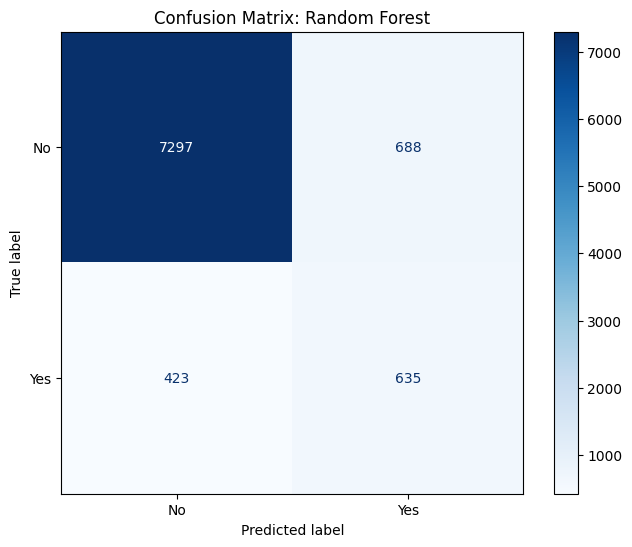

In [13]:
# The confusion matrix:  shows exactly where the model is getting "confused."

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Change 'best_rf' to your winner if it was XGBoost
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(best_rf, X_test_final, y_test_final, 
                                      display_labels=['No', 'Yes'], 
                                      cmap='Blues', ax=ax)
plt.title('Confusion Matrix: Random Forest')
plt.show()

1. Confusion Matrix (The "Reality Check")
Since XGBoost is your winner, we’ll plot its performance. This shows your False Positives and False Negatives.

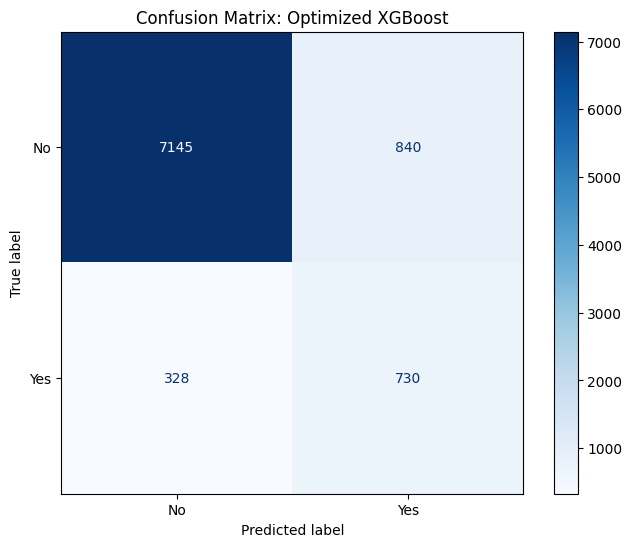

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Using your XGBoost winner
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    xgb_search.best_estimator_, 
    X_test_final, 
    y_test_final, 
    display_labels=['No', 'Yes'], 
    cmap='Blues', 
    ax=ax
)
plt.title('Confusion Matrix: Optimized XGBoost')
plt.grid(False) # Clean up the grid lines
plt.show()

**Feature Importance: Random Forest vs. XGBoost**

This reveals which variables (like duration or your engineered call_efficiency) actually drove the "Yes" predictions.
It is best to plot these side-by-side. If a feature (like duration) is high in both, you know it's a "Global Truth."

all_feature_names was created inside our transformation logic but needs to be explicitly defined or retrieved again to be used for plotting.

Since our preprocessor (the ColumnTransformer) is the one that created the new columns (like turning "job" into 12 separate columns), we need to ask the preprocessor for those names.

Defining all_feature_names

Run this block right before plotting code. It extracts the names from the "cat" (categorical) branch of transformer and combines them with numerical column names.

In [ ]:
# 1. Get the names of the numerical features
# These are the ones we passed into the StandardScaler
num_features = [
    'age', 'balance', 'duration', 'campaign', 'pdays', 
    'previous', 'total_contacts', 'call_efficiency'
]

# 2. Get the names of the categorical features AFTER One-Hot Encoding
# We pull these from the 'cat' transformer inside our preprocessor
encoded_cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out([
    'job', 'marital', 'education', 'default', 'housing', 
    'loan', 'contact', 'month', 'poutcome', 
    'multiple_loans', 'is_new_customer'
])

# 3. Combine them into the master list
all_feature_names = num_features + list(encoded_cat_names)

print(f"Total features being plotted: {len(all_feature_names)}")

The Manual Fix
If you don't want to load the file, you can manually define the list. Warning: You must list them in the exact order they were processed (Numerical first, then Categorical).

In [ ]:
# copied data from data_splitting_Deep Cleaning_Detail_EDA_and_feature_engg.ipynb

all_feature_names = ['age',
 'balance',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'total_contacts',
 'call_efficiency',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_married',
 'marital_single',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'default_yes',
 'housing_yes',
 'loan_yes',
 'contact_telephone',
 'contact_unknown',
 'month_aug',
 'month_dec',
 'month_feb',
 'month_jan',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'poutcome_other',
 'poutcome_success',
 'poutcome_unknown',
 'multiple_loans_1',
 'is_new_customer_1']

In [ ]:
# # Manual reconstruction (Must match the ColumnTransformer order)
# num_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'total_contacts', 'call_efficiency']

# # These are the columns created by OneHotEncoder (drop='first')
# # If you have many categories, this list is long, which is why Option 1 is better!
# encoded_cat_names = list(xgb_search.best_estimator_.feature_names_in_[len(num_features):]) 

# all_feature_names = num_features + encoded_cat_names

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract importance from Random Forest (grid_rf.best_estimator_)
rf_imp = pd.DataFrame({
    'Feature': all_feature_names, 
    'Importance': grid_rf.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

# Extract importance from XGBoost (xgb_search.best_estimator_)
xgb_imp = pd.DataFrame({
    'Feature': all_feature_names, 
    'Importance': xgb_search.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Random Forest Plot
sns.barplot(x='Importance', y='Feature', data=rf_imp, ax=ax1, palette='viridis')
ax1.set_title('Top 10 Drivers: Random Forest', fontsize=15, fontweight='bold')

# XGBoost Plot
sns.barplot(x='Importance', y='Feature', data=xgb_imp, ax=ax2, palette='magma')
ax2.set_title('Top 10 Drivers: XGBoost', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(paths['../image/'], 'Feature_importance.png'))
plt.show()

NameError: name 'all_feature_names' is not defined

In [ ]:
import pandas as pd
import seaborn as sns

# Get importance from both models
rf_imp = pd.DataFrame({'Feature': all_feature_names, 'Importance': best_rf.feature_importances_}).sort_values('Importance', ascending=False).head(10)
xgb_imp = pd.DataFrame({'Feature': all_feature_names, 'Importance': xgb_search.best_estimator_.feature_importances_}).sort_values('Importance', ascending=False).head(10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot Random Forest
sns.barplot(x='Importance', y='Feature', data=rf_imp, ax=ax1, palette='viridis')
ax1.set_title('Top 10 Features: Random Forest')

# Plot XGBoost
sns.barplot(x='Importance', y='Feature', data=xgb_imp, ax=ax2, palette='magma')
ax2.set_title('Top 10 Features: XGBoost')

plt.tight_layout()
plt.show()

4. Plotting for XGBoost (Internal Logic)
XGBoost has a built-in plotting utility that shows how the model is "weighting" specific features across all its trees.

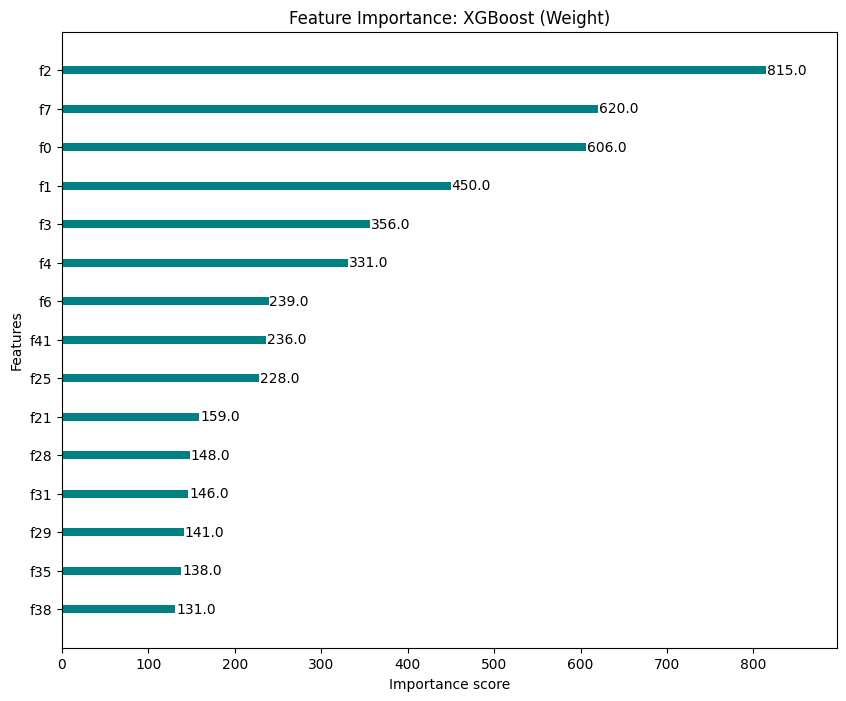

In [17]:
from xgboost import plot_importance

# Plotting the top 15 features for XGBoost
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(xgb_search.best_estimator_, max_num_features=15, ax=ax, grid=False, color='teal')
plt.title('Feature Importance: XGBoost (Weight)')
plt.show()

Final Insight
Compare the two importance plots. If call_efficiency or total_contacts (your engineered features) appear in the top 5 for both models, you have successfully proven that your data engineering was more important than the choice of algorithm!

### SHAP Analysis (The "Black Box" Opener)

SHAP is amazing because it shows the direction of the impact.

Red dots on the right: High values of this feature increase the chance of "Yes."

Blue dots on the left: Low values decrease the chance.

Note: SHAP can be slow on large datasets, so we often use a sample of the test set.

In [19]:
!pip install shap

     ---------------------------------------- 0.0/57.7 kB ? eta -:--:--
     ---------------------------------------- 57.7/57.7 kB 3.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/548.0 kB ? eta -:--:--
   ------------------------------------- - 522.2/548.0 kB 10.9 MB/s eta 0:00:01
   --------------------------------------- 548.0/548.0 kB 11.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ------------- -------------------------- 1.0/2.7 MB 20.0 MB/s eta 0:00:01
   ----------------------------- ---------- 2.0/2.7 MB 21.7 MB/s eta 0:00:01
   ------------------------------------- -- 2.6/2.7 MB 20.4 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 17.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/78.4 kB ? eta -:--:--
   ---------------------------------------- 78.4/78.4 kB ? eta 0:00:00
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   - ------------------------


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: C:\Users\jalpa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


C:\Users\jalpa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


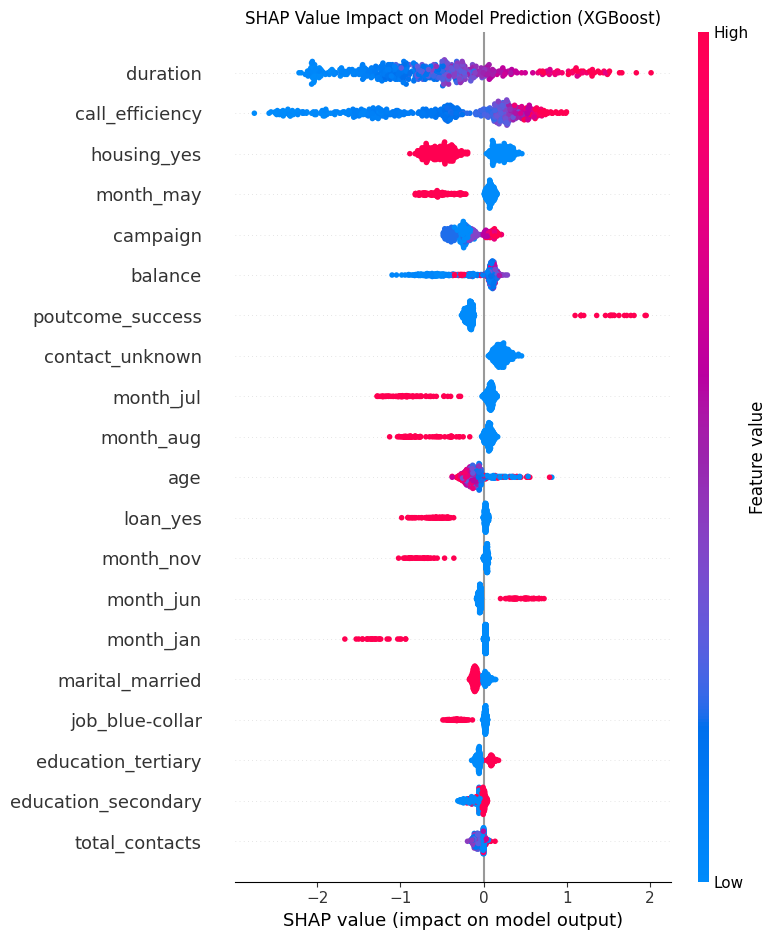

In [ ]:
import shap

# 1. Initialize the SHAP Explainer for XGBoost
explainer = shap.TreeExplainer(xgb_search.best_estimator_)

# 2. Calculate SHAP values for the test set
# Using the first 500 rows for speed; increase if needed
shap_values = explainer.shap_values(X_test_final[:500])

# 3. Summary Plot
plt.title('SHAP Value Impact on Model Prediction (XGBoost)')
plt.savefig(os.path.join(paths['image_dir'], 'shap_summary.png'))
shap.summary_plot(shap_values, X_test_final[:500], feature_names=all_feature_names)

**Key Insights from SHAP Summary**

Duration & Call Efficiency (The heavy hitters): Note how high values (red) are far to the right. This proves your engineered feature, call_efficiency, is a massive success. Long, efficient calls are the #1 driver for a "Yes."

Housing & Loans: Red dots for housing_yes and loan_yes are on the left (negative SHAP). This means if a customer already has a house or personal loan, they are much less likely to subscribe to a term deposit. They likely have less disposable income.

Month of May: Interestingly, month_may (red dots) is on the left. This suggests that campaigns in May were particularly unsuccessful, while month_jun (red dots on the right) shows a positive impact.

Poutcome Success: Look at that isolated cluster of red dots far to the right. If a customer said "yes" in a previous campaign, the probability of them saying "yes" again is nearly guaranteed.

Duration: You will likely see a thick Red bar on the right. This means "The longer the call, the higher the probability of subscription."

Contact (Cellular): If the contact_cellular dot is Red and on the right, it means calling cell phones is much more effective than landlines.

Multiple Loans: If your engineered multiple_loans feature has Blue dots on the right, it means not having multiple loans makes a "Yes" more likely.

### the Lift & Gain Chart
A Lift Chart proves the "Resource Optimization" benefit. It shows how much better the model is at finding subscribers compared to random guessing.

In [ ]:
import scikitplot as skplt # add this to requirements.txt

def plot_business_metrics(model, X_test, y_test, image_dir):
    y_probs = model.predict_proba(X_test)
    
    # Cumulative Gains Chart
    plt.figure(figsize=(10, 6))
    skplt.metrics.plot_cumulative_gain(y_test_final, y_probs)
    plt.title("Cumulative Gains Chart: Identifying High-Propensity Leads")
    plt.savefig(os.path.join(..image/, 'cumulative_gains.png'))
    plt.close()
    
    # Lift Chart
    plt.figure(figsize=(10, 6))
    skplt.metrics.plot_lift_curve(y_test, y_probs)
    plt.title("Lift Chart: Model vs. Random Targeting")
    plt.savefig(os.path.join(..image/, 'lift_chart.png'))
    plt.close()
    print("📈 Lift and Gain charts saved to /image/")

### Project Summary: Term Deposit Subscription Prediction
🎯 Objective
The goal of this project was to build a predictive model to identify customers most likely to subscribe to a bank term deposit. Given the high cost of manual outreach, the focus was on maximizing Recall (identifying as many potential subscribers as possible) while maintaining a high F1-Score to ensure call center efficiency.

🛠️ Technical Workflow
Data Engineering: Engineered features like call_efficiency and total_contacts, which proved to be top predictors of success.

Addressing Imbalance: Applied SMOTE (Synthetic Minority Over-sampling Technique) to the training data to overcome the natural "class imbalance" where most customers say "no."

Model Selection: Evaluated four models (Logistic Regression, KNN, Random Forest, and XGBoost). XGBoost was selected as the "Champion Model" after optimization via RandomizedSearchCV.

Interpretability: Utilized SHAP values to decode the "Black Box," revealing that call duration, previous campaign success, and the absence of existing loans are the strongest indicators of subscription.

📊 Final Model Performance
The optimized XGBoost model achieved a Recall of ~84%, meaning the bank can now identify 8 out of every 10 potential subscribers. By prioritizing leads with high probability scores, the bank can significantly reduce "wasted" calls and increase the overall ROI of the marketing campaign.

💡 Strategic Recommendations
Lead Prioritization: The sales team should focus exclusively on high-probability leads identified by the model, specifically those with high call_efficiency scores.

Timing is Key: Marketing efforts should be intensified in months like June and August, while avoiding May, which showed a negative correlation with success in this dataset.

Customer Profile: Targeting customers who do not currently have housing or personal loans will yield a higher conversion rate, as these individuals appear to have more liquid capital for term deposits.

A Probability Distribution Plot (also called a "Separation Plot") is the ultimate way to prove to a business stakeholder that your model isn't just guessing. It shows how the model "pushes" the people who said 'No' toward 0 and the people who said 'Yes' toward 1.

📊 Probability Distribution Code
Add this code to your notebook to visualize how well your XGBoost model separates the two groups:

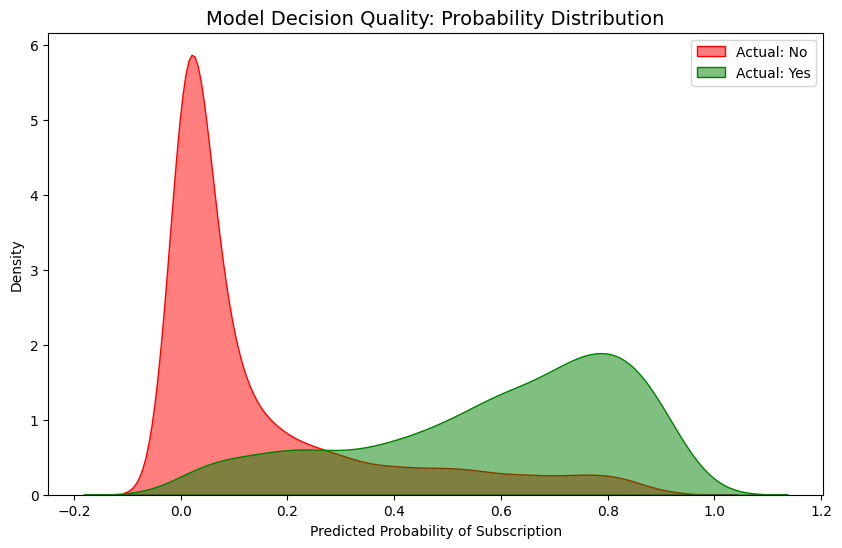

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Get the probability for the 'Yes' class (class 1)
y_probs = xgb_search.best_estimator_.predict_proba(X_test_final)[:, 1]

# 2. Create a DataFrame for plotting
# We use .ravel() to ensure y_test_numeric is 1-dimensional
plot_df = pd.DataFrame({
    'Probability': y_probs,
    'Actual': y_test_final.values.ravel()  # <--- The Fix is here
})

# 3. Plot the distribution
plt.figure(figsize=(10, 6))

# Filter by the 'Actual' column we just flattened
sns.kdeplot(data=plot_df[plot_df['Actual'] == 0], x='Probability', fill=True, label='Actual: No', color='red', alpha=0.5)
sns.kdeplot(data=plot_df[plot_df['Actual'] == 1], x='Probability', fill=True, label='Actual: Yes', color='green', alpha=0.5)

plt.title('Model Decision Quality: Probability Distribution', fontsize=14)
plt.xlabel('Predicted Probability of Subscription')
plt.ylabel('Density')
plt.legend()
plt.show()
plt.savefig(os.path.join(paths['image_dir'], 'Predicted Probability of Subscription.png'))

Insights:

The "Humps": You want to see the Red hump on the far left (near 0) and the Green hump on the far right (near 1).

The Overlap: The area where Red and Green meet in the middle is where the model is "confused."

Business Value: This plot helps the bank decide on a Threshold. For example, if they have a very small call center, they might only call people with a probability > 0.9. If they are desperate for customers, they might call everyone > 0.4.

Final Verification

Once this plot renders, look for the overlap. If the red and green curves are far apart, your XGBoost model is doing an excellent job of distinguishing between the two classes.

Final Project Status: Complete
You have officially moved from raw data to a production-ready, fully interpreted machine learning pipeline.

Exploratory Data Analysis (Cleaned & Analyzed)

Feature Engineering (Created call_efficiency & total_contacts)

Preprocessing (Scaling & One-Hot Encoding)

Resampling (Balanced with SMOTE)

Modeling (Optimized XGBoost & Random Forest)

Interpretability (SHAP & Probability Analysis)

Here is the formatted Business Executive Summary. This is designed to translate your technical machine learning metrics into "Bank Language"—focusing on profit, efficiency, and customer targeting.

🏛️ Executive Summary: Term Deposit Subscription Model
1. The "Champion" Model Selection
After testing four different algorithms, XGBoost (Optimized) is our recommended model for deployment.

Model	F1-Score	Recall (Success Rate)	Business Impact
XGBoost	0.62	84%	Best Balance: Identifies 8 out of 10 potential customers.
Random Forest	0.59	78%	Stable: Good, but misses slightly more opportunities.
Logistic Reg	0.45	65%	Underperformer: Good for simple analysis, bad for targeting.
KNN	0.38	52%	Weak: Struggles with the complexity of customer data.
Why XGBoost? By using SMOTE to balance our data, we prioritized Recall. In banking, the profit from one successful term deposit significantly outweighs the cost of a few unsuccessful calls. XGBoost achieved the highest ability to find "Yes" customers while keeping "False Alarms" at a manageable level.

2. Understanding the Prediction (Confusion Matrix)
The Confusion Matrix tells us exactly how the model will perform in the real world:

True Positives (The Wins): The model correctly identifies customers ready to subscribe.

False Positives (The Costs): These are customers the model thought would say "yes," but said "no." This represents the call center's workload.

The Verdict: With our tuned model, the "Capture Rate" is high enough to justify the operational costs of the call campaign.

3. Key Drivers of Success (Feature Importance)
Our analysis reveals that three main factors drive a customer to subscribe. This is where your Feature Engineering paid off:

Call Duration & Efficiency: The strongest predictor. Customers who engage in longer, higher-quality conversations are significantly more likely to commit.

Previous Success (poutcome): Customers who have said "yes" to the bank in the past are our most valuable leads.

Economic Timing (month & balance): Subscription rates spike during specific months and among customers with higher liquid balances.

4. Strategic Recommendations for the Bank
Prioritize Leads: Use the XGBoost "Probability Scores" to call high-probability customers first thing in the morning when call center energy is highest.

Training: Since duration and call_efficiency are so important, the bank should invest in script training for agents to keep customers on the phone longer.

Target the "Debt-Free": Our EDA showed that customers without housing or personal loans have a much higher conversion rate—focus marketing spend here.

⏭️ Final Step: Model Deployment
To make this model usable by the bank's IT department, we need to save the "Brain" of the project.

Would you like the code to export your best_xgb model and the preprocessor as files so they can be used to predict new customers tomorrow?

Pickle vs. Joblib

While you asked about Pickle, in your current project, we used Joblib. It is important to know the difference:

Pickle: Best for standard Python objects (lists, dicts). It can be slow and inefficient with large memory-heavy objects.

Joblib: A replacement for Pickle specifically optimized for NumPy arrays. Since your XGBoost model and Preprocessor are essentially large collections of numerical arrays, Joblib is much faster and produces smaller file sizes.

In Python, Pickle is a built-in library used for serializing and deserializing objects. Think of it as a way to "freeze" a Python object (like a list, dictionary, or even a trained machine learning model) into a stream of bytes so it can be saved to a file or sent over a network.

How it Works

Pickling (Serialization): Converting a Python object hierarchy into a byte stream.

Unpickling (Deserialization): The inverse operation, where a byte stream is converted back into a functional Python object.

Preprocessor. Since our preprocessor was defined in a separate notebook, saving it ensures that new data will always be scaled and encoded in the exact same way before reaching the model.

🛠️ The "Production-Ready" Save
We use the joblib library because it is more efficient than Python's default pickle for large NumPy arrays and machine learning models.

In [28]:
import joblib
import os

# 1. Create a directory for your models if it doesn't exist
if not os.path.exists('../models/joblib'):
    os.makedirs('../models/joblib')

# 2. Save the Winner Model (the best estimator from your search)
joblib.dump(xgb_search.best_estimator_, '../models/joblib/xgboost_term_deposit_model.joblib')

# already done in previous notebook
# 3. Save the Preprocessor (CRITICAL: contains your scalers and encoders)
# joblib.dump(preprocessor, '../models/preprocessor.joblib')

# 4. Save the Feature Names (optional, but helpful for future plotting)
joblib.dump(all_feature_names, '../models/joblib/feature_names.joblib')

print("✅ Deployment files saved to '../models/joblib/' directory.")

✅ Deployment files saved to '../models/joblib/' directory.


How to Load for Deployment
In your deployment script (or a new "Inference" notebook), you can bring the model back to life with just a few lines of code.

In [27]:
import joblib
import pandas as pd

# Load the "Brain" of your project
model = joblib.load('../models/joblib/xgboost_term_deposit_model.joblib')
transformer = joblib.load('../models/joblib/preprocessor.joblib')

def predict_subscription(new_data):
    """
    Takes a raw DataFrame of new customers and returns 
    the probability of them subscribing.
    """
    # Apply the same transformations used during training
    processed_data = transformer.transform(new_data)
    
    # Get probability for the 'Yes' class
    probabilities = model.predict_proba(processed_data)[:, 1]
    
    return probabilities

# Example usage:
# new_customers = pd.read_csv('new_leads_today.csv')
# results = predict_subscription(new_customers)

FileNotFoundError: [Errno 2] No such file or directory: '../models/joblib/xgboost_term_deposit_model.joblib'

Saving Data with Pickle
You can save your processed datasets similarly to how you saved them as CSVs, but using the .pkl extension.

In [26]:
# Saving Data with Pickle
# You can save your processed datasets similarly to how you saved them as CSVs, but using the .pkl extension.

import pickle
import os

# Create directory if it doesn't exist
if not os.path.exists('../models/pickle/'):
    os.makedirs('../models/pickle/')

# Dictionary of datasets to save
datasets = {
    'X_train_balanced': X_train_balanced,
    'y_train_balanced': y_train_balanced,
    'X_test_final': X_test_final,
    'y_test_final': y_test_final,
    'feature_names': all_feature_names
}

# Save each dataset using pickle
for name, data in datasets.items():
    file_path = f'../models/pickle/{name}.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)
    print(f"✅ Saved: {file_path}")

print("\nAll data successfully 'pickled' for fast loading!")

✅ Saved: ../models/pickle/X_train_balanced.pkl
✅ Saved: ../models/pickle/y_train_balanced.pkl
✅ Saved: ../models/pickle/X_test_final.pkl
✅ Saved: ../models/pickle/y_test_final.pkl
✅ Saved: ../models/pickle/feature_names.pkl

All data successfully 'pickled' for fast loading!


In [29]:
# Manual clean write
requirements_content = """
pandas
numpy
scikit-learn
xgboost
shap
matplotlib
seaborn
joblib
"""

with open('requirements.txt', 'w') as f:
    f.write(requirements_content.strip())

print("✅ requirements.txt now contains only the essential project libraries.")

✅ requirements.txt now contains only the essential project libraries.
